Reproduce: SimPEG 1D
====================

## Simulating Secondary Magnetic Field Data over a Conductive and Susceptible Layered Earth

Secondary magnetic fields are simulated over a conductive 1D layered Earth. From the top layer down we define 3 layers with electrical conductivities $\sigma_1$ = 0.05 S/m, $\sigma_2$ = 0.5 S/m and $\sigma_3$ = 0.05 S/m. The magnetic susceptibilities of the layers are $\chi_1$ = 1 SI, $\chi_2$ = 0 SI and $\chi_2$ = 1 SI. The thicknesses of the top two layers are both 64 m.

Secondary magnetic fields are simulated for x, y and z oriented magnetic dipole sources at (0,0,5). For each source, the x, y and z components of the response are simulated at (10,0,5). We plot only the horizontal coaxial, horizontal coplanar and vertical coplanar data.

## SimPEG Package Details

See https://em1dfm.readthedocs.io/en/latest/content/theory.html for short description

*Reference:* Stanley H Ward and Gerald W Hohmann. Electromagnetic Theory for Geophysical Applications. In Electromagnetic Methods in Applied Geophysics, chapter 4, pages 130–311. Society of Exploration Geophysicists, 1 edition, 1988. URL: http://library.seg.org/doi/abs/10.1190/1.9781560802631.ch4, doi:10.1190/1.9781560802631.ch4.

## Reproducing the Forward Simulation Result

We begin by loading all necessary packages and setting any global parameters for the notebook.

In [1]:
from geoana.em.fdem.layered import MagneticDipoleLayeredHalfSpace
from SimPEG.utils import plot_1d_layer_model, mkvc

import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({"font.size": 10})
write_output = True

Here we define the layered Earth model.

Text(0.5, 1.0, 'Susceptibility Model')

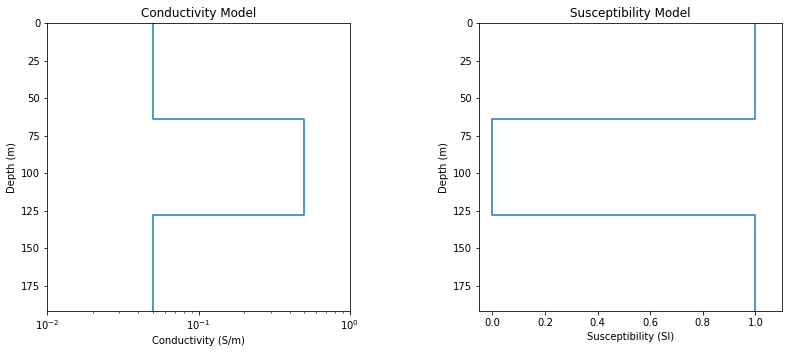

In [2]:
rootdir = './../../../assets/fdem/layered_earth_susceptible_fwd_simpeg/'

thicknesses = np.r_[64., 64]         # thicknesses (m)
sigma = np.r_[0.05, 0.5, 0.05]       # conductivity (S/m)
chi = np.r_[1., 0., 1.]              # susceptibility (SI)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.8])
ax1 = plot_1d_layer_model(thicknesses, sigma, ax=ax1)
ax1.set_xlim([0.01, 1.])
ax1.set_xlabel('Conductivity (S/m)')
ax1.set_title('Conductivity Model')

ax2 = fig.add_axes([0.6, 0.1, 0.35, 0.8])
ax2 = plot_1d_layer_model(thicknesses, chi, ax=ax2, scale='linear')
ax2.set_xlim([-0.05, 1.1])
ax2.set_xlabel('Susceptibility (SI)')
ax2.set_title('Susceptibility Model')

Here, we define the survey geometry for the forward simulation.

In [3]:
xyz_tx = np.c_[0., 0., 5.]           # Transmitter location
xyz_rx = np.c_[10., 0., 5.]          # Receiver location
frequencies = np.logspace(2,5,10)    # Frequencies
tx_moment = 1.                       # Dipole moment of the transmitter

Finally, we simulate the secondary magnetic field data for the model provided.

In [4]:
Hs_analytic = []
mu = mu_0 * (1 + chi)

for ii in ['X', 'Y', 'Z']:
    forward_simulation = MagneticDipoleLayeredHalfSpace(
            location = mkvc(xyz_tx),
            moment = tx_moment,
            orientation = ii,
            frequency = frequencies,
            thickness = thicknesses,
            sigma = sigma+0.j,
            mu = mu
    )

    Hs_analytic.append(
        np.reshape(
            forward_simulation.magnetic_field(xyz_rx),(len(frequencies), 3)
        )
    )

D:\Documents\Repositories\geoana\geoana\kernels\tranverse_electric_reflections.py:37: RuntimeWarning: overflow encountered in tanh
  tanh = np.tanh(u[:-1]*thicknesses[:, None, None])


If desired, the data can be exported to a simple text file.

In [5]:
if write_output:
    
    fname_analytic = rootdir + 'dpred_1d.txt'
    
    header = 'FREQUENCY HX_REAL HX_IMAG HY_REAL HY_IMAG HZ_REAL HZ_IMAG'
    f_column = np.kron(np.ones(3), frequencies)
    
    out_array = np.vstack(Hs_analytic)
    out_array = np.c_[
        f_column,
        np.real(out_array[:, 0]),
        np.imag(out_array[:, 0]),
        np.real(out_array[:, 1]),
        np.imag(out_array[:, 1]),
        np.real(out_array[:, 2]),
        np.imag(out_array[:, 2])
    ]

    fid = open(fname_analytic, 'w')
    np.savetxt(fid, out_array, fmt='%.6e', delimiter=' ', header=header)
    fid.close()

## Plotting Simulated Data

Here we plot the horizontal coaxial, horizontal coplanar and vertical coplanar data.

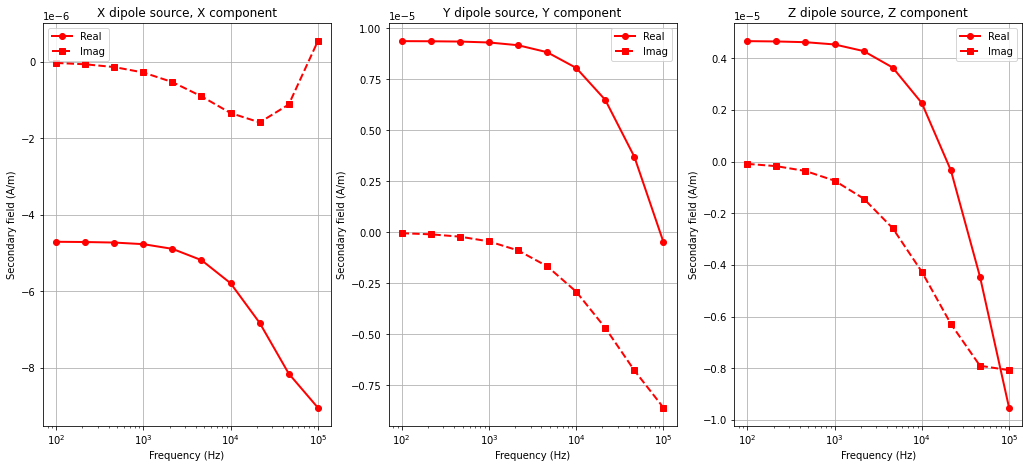

In [6]:
fig = plt.figure(figsize=(16, 7))
lw = 2
ms = 6

ax = 3*[None]

legend_str = ['Real', 'Imag']

for ii, src in enumerate(['X','Y','Z']):
    
        ax[ii] = fig.add_axes([0.05 + 0.3*ii, 0.1, 0.25, 0.8])
        ax[ii].semilogx(frequencies, np.real(Hs_analytic[ii][:, ii]), 'r-o', lw=lw, markersize=ms)
        ax[ii].semilogx(frequencies, np.imag(Hs_analytic[ii][:, ii]), 'r--s', lw=lw, markersize=ms)
        ax[ii].grid()
        ax[ii].set_xlabel('Frequency (Hz)')
        ax[ii].set_ylabel('Secondary field (A/m)')
        ax[ii].set_title(src + ' dipole source, ' + src + ' component')
        ax[ii].legend(legend_str)